# Fashion Product Recommendation using Multimodel Data #

Done By
BadriNarayanan S (2348507)

### Problem Statement ###

A fashion e-commerce platform aims to improve its product recommendation system to increase user engagement and sales. The company wants to develop a system that can recommend fashion items to users based on their preferences and browsing history, leveraging both textual product descriptions and visual features extracted from product images.

### Dataset Description ###

Fashion product dataset provides detailed information about fashion products, making it suitable for various analyses, including trend analysis, category-wise distribution, color preferences, and more. Further exploration and analysis could reveal valuable insights into consumer preferences and market trends in the fashion industry.

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fashion-product-images-small/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/images/31973.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/30778.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/19812.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/22735.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/38246.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/16916.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/52876.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/39500.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44758.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/59454.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44951.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/

##  Loading required packages ##

In [2]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
import warnings
from sklearn.metrics.pairwise import linear_kernel

2024-04-23 17:54:29.342349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 17:54:29.342467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 17:54:29.462663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Displaying the directory details ##

In [3]:
path = '../input/fashion-product-images-small/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path)
dirs_names

['myntradataset', 'images', 'styles.csv']

## Visualizing some images from the fashion dataset ##

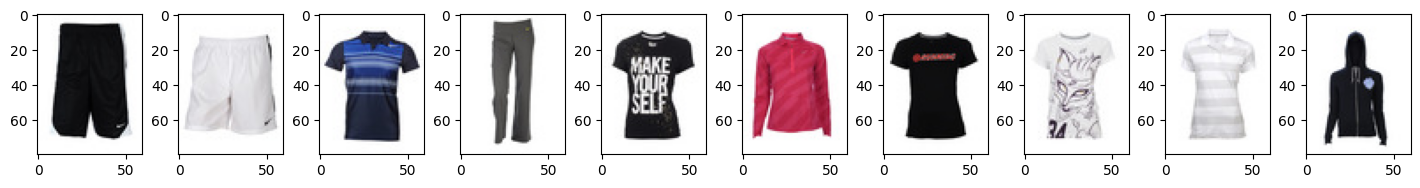

In [4]:
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

## Inference ##

Displayed some random images from the fashion product images dataset.

## Reading the fashion product dataset ##

In [5]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000) # Reading 6000 product
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Making image column contains (id.jpg)
print(styles_df.shape)
styles_df.head(5)

(6000, 11)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg

## Inference ##

Reading the first 6000 product of the dataset, since some rows in the dataset created issues. 

In [6]:
styles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  6000 non-null   int64 
 1   gender              6000 non-null   object
 2   masterCategory      6000 non-null   object
 3   subCategory         6000 non-null   object
 4   articleType         6000 non-null   object
 5   baseColour          6000 non-null   object
 6   season              5998 non-null   object
 7   year                6000 non-null   int64 
 8   usage               5946 non-null   object
 9   productDisplayName  5999 non-null   object
 10  image               6000 non-null   object
dtypes: int64(2), object(9)
memory usage: 515.8+ KB


## Inference ##

There is not that much null values in the dataset

## Visualizing the count of all the Image Classes in the dataset ##

<Axes: ylabel='articleType'>

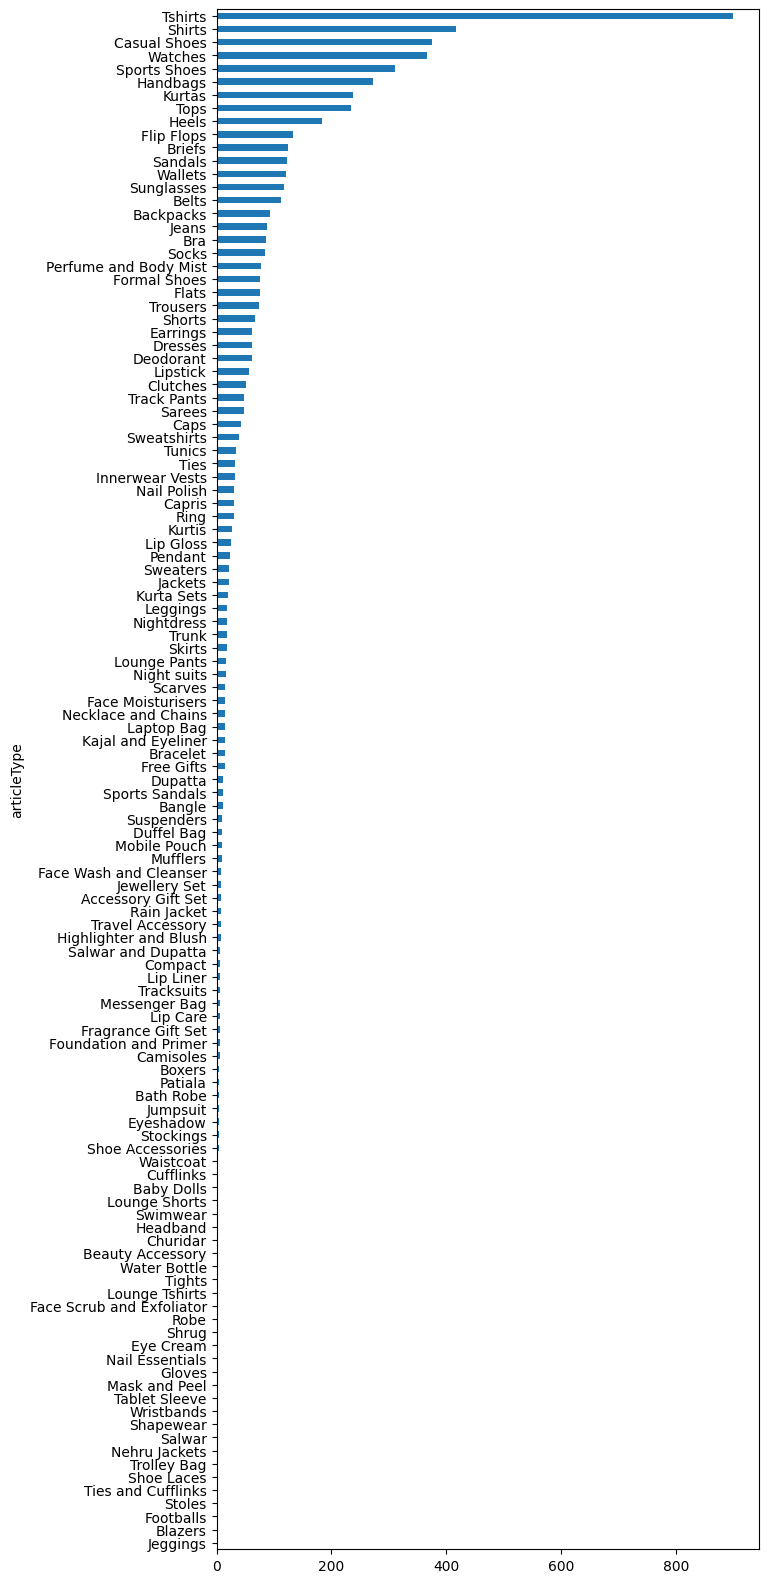

In [7]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

## Inference ##

Displayed the count of all the image classes in the dataset.

# Image Embeddings #

### Setting width, height and channels of the image ###

In [8]:
img_width, img_height, chnls = 100, 100, 3

# Pretrained VGG16 Model #

In [9]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Inference ##

Loading the pre-trained VGG16 model for feature extraction. VGG16 is a convolutional neural network used for image classification. 

In [10]:
def img_path(img):
    return path + 'images/' + img

### Load and preprocess Image then make prediction ###

In [11]:
def predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [12]:
def get_embeddings(df, model):
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


I0000 00:00:1713894895.885238      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

## Inference ##

It will return a dataframe contains images features.

In [13]:
df_embeddings.to_csv("/kaggle/working/df_embeddings.csv", index=False)

In [14]:
df_embeddings.head(5)

0            1             2            3             4    \
0  19292.394531 -1680.391846  42944.683594  -129.876343  11451.662109   
1  24049.050781  6832.820312  44846.324219    63.409668  25189.888672   
2  10718.498047  3818.406006  29022.679688  5715.009766   3849.082275   
3  18595.851562  3606.772217  35488.445312 -1520.650879  24764.367188   
4  15311.520508   963.197388  32146.177734  1542.184326   9625.877930   

            5            6            7             8            9    ...  \
0   4545.268555   700.841309    26.893372  14225.503906 -4811.883789  ...   
1  12166.674805  6221.254883  5059.788574  34425.050781  1809.877930  ...   
2   4950.748047  3208.636719  1707.468872   7734.973145  1474.336060  ...   
3  10877.269531  7611.416016  4393.235840  34020.726562  -678.406067  ...   
4   4835.029297  1621.015259   606.280029  15596.196289 -1972.659424  ...   

           502          503           504           505           506  \
0  -789.727966  2117.441895  14995.848633  10179.845703  31038.556641   
1  -781.958740  8313.136719  23807.519531  18021.054688  18876.466797   
2  1456.153931  1574.926636   9289.704102   2889.013184   4708.577148   
3 -2683.529785  7199.373047  18672.791016  11275.879883  11165.458008   
4  -533.769165  1604.730591  14001.205078   6593.647949  13078.520508   

           507          508          509          510           511  
0  1310.942261  1695.016113 -6485.078125  -460.719421   -620.935913  
1  2616.551514  4642.306641 -2011.167236  2741.653076  16231.769531  
2  1640.133057  3408.740967   609.458252  1481.400879    342.566162  
3  2603.920166  4716.622559 -2288.909912   733.507080  15178.023438  
4  1679.257568  3189.771484 -3957.397949   859.023560   3364.682373  

[5 rows x 512 columns]

# Reading a Image

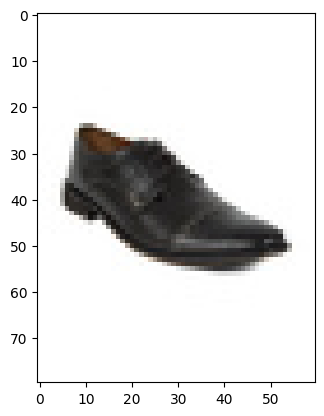

In [15]:
link="../input/fashion-product-images-small/images/10171.jpg"
a = plt.imread(link)
plt.imshow(a)

In [16]:
sampleImage = predict(vgg16_model, '10171.jpg')
sampleImage.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(1, 512)

In [17]:
df_sample_image = pd.DataFrame(sampleImage)  
print(df_sample_image)

            0            1             2             3            4    \
0  14900.237305  7787.427246  29777.207031  14970.320312  2161.788086   

            5            6            7             8            9    ...  \
0  11692.931641  7021.848633  3429.290283  17664.679688  6780.313965  ...   

           502          503           504          505          506  \
0  5423.422363  4961.371094  13923.485352  2381.276855  3059.014648   

           507          508          509          510          511  
0  2619.133545  5028.410645  2321.068604  2317.720459  4605.066406  

[1 rows x 512 columns]


In [18]:
sampleSimilarity = linear_kernel(df_sample_image, df_embeddings)
print(sampleSimilarity)

[[4.7209013e+10 6.4200380e+10 3.1181910e+10 ... 3.4189154e+10
  3.7374673e+10 5.2737901e+10]]


In [19]:
def getSimilarity(model):
    sample_image = predict(vgg16_model, '10130.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [20]:
def normalizeSim(similarity):
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

In [21]:
sample_similarity_norm = normalizeSim(sampleSimilarity)
sample_similarity_norm.shape

(1, 6000)

In [22]:
def getRecommendations(df, similarity):
    
    sim_scores = list(enumerate(similarity[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    cloth_indices = [i[0] for i in sim_scores]
    return df['image'].iloc[cloth_indices]

[(5427, 1.0), (806, 0.7967044), (4382, 0.7682423), (5139, 0.7479657), (2186, 0.7399823)]


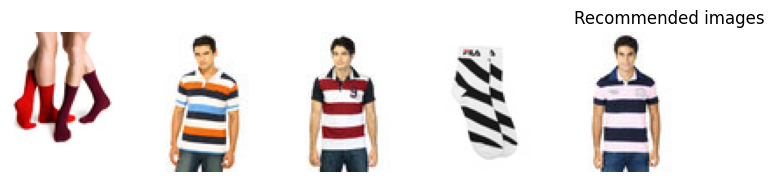

In [23]:
recommendation = getRecommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()

#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Conclusion #

